# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
!pip -q install typing_extensions

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent) 
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque

from buffer import ReplayMemory, PrioritizedMemory
from agent import Agent

In [7]:
# System arguments
params = {
    'buffer_size': int(1e6),
    'batch_size': 128,
    'gamma': 0.99,
    'tau': 7e-3,
    'lr': 6.25e-5,
    'epsilon': 1,
    'epsilon_decay': 1e-4,
    'epsilon_decay_type': 'linear',  # 'linear' or 'exponential'
    'min_experience': 4096,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'n_steps': 4,
    'learning_iters': 5,
    'extensions': ['Prioritized Replay'],
    'layer_units': [256, 256],
    'ou_theta': 0.2,
    'ou_sigma': 0.15,
    'saved_frames': 3,
}

In [8]:
def train_agent(n_episodes=500, max_t=1000, solved_score=0.5, greedy_score=1.5, consec_episodes=100, print_every=1, train_mode=True):
    scores_list = []                                    # list containing scores from each episode
    scores_window = deque(maxlen=consec_episodes)       # last `consec_episodes` scores
    moving_average = []
    solved=False
    
    for i_episode in range(1, n_episodes+1):
        # Reset environment
        env_info = env.reset(train_mode=train_mode)[brain_name]
        # Extract initial state
        states = env_info.vector_observations
        # Prepare scores vector
        scores = np.zeros(num_agents)
        # Reset agent's noise
        agent.reset()

        for t in range(max_t):
            # Select agent's action
            action_0 = agent.act(states[0])
            action_1 = agent.act(states[1])
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            
            # Send action to the environment
            env_info = env.step(actions)[brain_name]
            # Get state update
            next_states = env_info.vector_observations
            # Get action reward
            rewards = env_info.rewards
            # Check if episode has concluded
            dones = env_info.local_done
            
            # Save tuples in buffer
            # for i in range(len(rewards)):
                # agent.save_experience(full_state, actions[i], rewards[i], full_next_state, dones[i], i)
                
            agent.step(states[0], action_0, rewards[0], next_states[0], dones[0])
            agent.step(states[1], action_1, rewards[1], next_states[1], dones[1])
            
            # Update episode's state and scores
            states = next_states
            scores += rewards
            
            # Exit loop if episode has concluded
            if np.any(dones): break

        # Save scores
        scores_window.append(np.max(scores))
        scores_list.append(np.max(scores))
        moving_average.append(np.mean(scores_window))
        
        # Visualization
        # print('\rEpisode {}\tMean Score: {:.2f}'.format(i_episode, scores_window[-1], end=""))
        if i_episode % print_every == 0:
            min_score = np.min(scores_list[-print_every:])
            max_score = np.max(scores_list[-print_every:])
            mean_score = np.mean(scores_list[-print_every:])
            print('Episode {}\tMean Score: {:.3f}\tMin Score: {:.3f}  |  Max Score: {:.3f}'.format(i_episode, mean_score, min_score, max_score, end=""))
            
        if np.mean(scores_window) >= solved_score and i_episode > consec_episodes and not solved:
            print('\nEnvironment solved in {: d} episodes!\tMean Score: {: .3f}\n'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent._actor_local.state_dict(), 'main_actor_weights.pth')
            torch.save(agent._critic_local.state_dict(), 'main_critic_weights.pth')
            solved = True
            
        if np.mean(scores_window) >= greedy_score and i_episode > consec_episodes:
            print('\nGreedy score reached in {: d} episodes!\tMean Score: {: .3f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent._actor_local.state_dict(), 'greedy_actor_weights.pth')
            torch.save(agent._critic_local.state_dict(), 'greedy_critic_weights.pth')
            break
            
            
    return scores_list, moving_average
    

In [9]:
agent = Agent(state_size, action_size, params)
scores, moving_average = train_agent(n_episodes=2000, print_every=10)

Episode 10	Mean Score: 0.020	Min Score: 0.000  |  Max Score: 0.100
Episode 20	Mean Score: 0.010	Min Score: 0.000  |  Max Score: 0.100
Episode 30	Mean Score: 0.020	Min Score: 0.000  |  Max Score: 0.100
Episode 40	Mean Score: 0.010	Min Score: 0.000  |  Max Score: 0.100
Episode 50	Mean Score: 0.010	Min Score: 0.000  |  Max Score: 0.100
Episode 60	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 70	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 80	Mean Score: 0.010	Min Score: 0.000  |  Max Score: 0.100
Episode 90	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 100	Mean Score: 0.030	Min Score: 0.000  |  Max Score: 0.100
Episode 110	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 120	Mean Score: 0.010	Min Score: 0.000  |  Max Score: 0.100
Episode 130	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 140	Mean Score: 0.000	Min Score: 0.000  |  Max Score: 0.000
Episode 150	Mean Score: 0.000	Min Score: 0.000  |  Max Sc

In [10]:
def print_results(results, average):
    fig = plt.figure()
    plt.plot(np.arange(len(results)), results)
    plt.plot(np.arange(len(results)), average, c='r')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

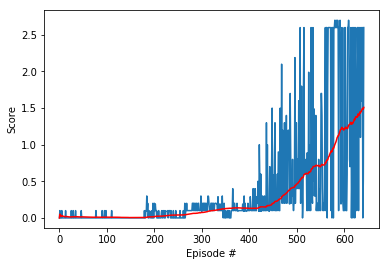

In [11]:
print_results(scores, moving_average)